<a href="https://colab.research.google.com/github/smkim0508/COS484-Notes/blob/main/A1P2_Classification_(COS484_S2026).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Programming Question 2
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a written portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

We'll also be programming in Python, which we will assume a basic familiarity with. Python has fantastic community support and we'll be using numerous packages for machine learning (ML) and natural language processing (NLP) tasks.

### Learning Objectives
In this problem we will implement logistic regression and test it on a sentiment analysis dataset.

### Data Loading and Feature Extraction

##### You will need to implement a method that processes raw text into feature vectors by mapping vocabulary terms to unique indices. Your implementation needs to support Unigram extraction, where features represent individual word counts, as well as Bigram extraction, where features represent consecutive word pair counts. Make sure your setup correctly handles feature indexing so that the same mapping is applied to both training and development data.

In [ ]:
# first need to build vocabulary
import os

# download data into data/... dir
if not os.path.exists('data'):
    os.makedirs('data')

# training
!wget -P data/ https://princeton-nlp.github.io/cos484/assignments/a1/train.txt
# dev
!wget -P data/ https://princeton-nlp.github.io/cos484/assignments/a1/dev.txt

# helper to load data and parse it
def load_data(path):
  data = []
  with open(path, "r") as f:
    for line in f:
        parts = line.strip().split()
        label = int(parts[0])
        tokens = parts[1:]
        data.append((label, tokens))
  return data

# load in train and dev data
train_data = load_data("data/train.txt")
dev_data   = load_data("data/dev.txt")

--2026-02-17 03:04:11--  https://princeton-nlp.github.io/cos484/assignments/a1/train.txt
Resolving princeton-nlp.github.io (princeton-nlp.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to princeton-nlp.github.io (princeton-nlp.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 738844 (722K) [text/plain]
Saving to: ‘data/train.txt.9’

train.txt.9         100%[===================>] 721.53K  --.-KB/s    in 0.004s  

2026-02-17 03:04:11 (172 MB/s) - ‘data/train.txt.9’ saved [738844/738844]

--2026-02-17 03:04:11--  https://princeton-nlp.github.io/cos484/assignments/a1/dev.txt
Resolving princeton-nlp.github.io (princeton-nlp.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to princeton-nlp.github.io (princeton-nlp.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94400 (92K) [text/plain]
Saving to: ‘data/dev.txt.9’

dev.txt.9   

In [12]:
# helper to build UNIGRAM vocab from train data
def build_unigram_vocab(train_data):
  vocab = {}

  def add_feature(feat):
    if feat not in vocab:
      vocab[feat] = len(vocab) # set value as unique idx that auto-increments

  for label, tokens in train_data:
    # unigram features
    for w in tokens:
      add_feature(w)

  return vocab

# helper to build BIGRAM vocab from train data
def build_bigram_vocab(train_data):
  vocab = {}

  def add_feature(feat):
    if feat not in vocab:
      vocab[feat] = len(vocab) # set value as unique idx that auto-increments

  for label, tokens in train_data:
    # bigram features
    for i in range(len(tokens)-1):
      add_feature(tokens[i] + "_" + tokens[i+1])

  return vocab

vocab = build_bigram_vocab(train_data)
print(vocab)

{'a_stirring': 0, 'stirring_,': 1, ',_funny': 2, 'funny_and': 3, 'and_finally': 4, 'finally_transporting': 5, 'transporting_re-imagining': 6, 're-imagining_of': 7, 'of_beauty': 8, 'beauty_and': 9, 'and_the': 10, 'the_beast': 11, 'beast_and': 12, 'and_1930s': 13, '1930s_horror': 14, 'horror_films': 15, 'apparently_reassembled': 16, 'reassembled_from': 17, 'from_the': 18, 'the_cutting-room': 19, 'cutting-room_floor': 20, 'floor_of': 21, 'of_any': 22, 'any_given': 23, 'given_daytime': 24, 'daytime_soap': 25, 'soap_.': 26, 'they_presume': 27, 'presume_their': 28, 'their_audience': 29, 'audience_wo': 30, "wo_n't": 31, "n't_sit": 32, 'sit_still': 33, 'still_for': 34, 'for_a': 35, 'a_sociology': 36, 'sociology_lesson': 37, 'lesson_,': 38, ',_however': 39, 'however_entertainingly': 40, 'entertainingly_presented': 41, 'presented_,': 42, ',_so': 43, 'so_they': 44, 'they_trot': 45, 'trot_out': 46, 'out_the': 47, 'the_conventional': 48, 'conventional_science-fiction': 49, 'science-fiction_elements

### Model Implementation

You should implement a class that supports the logistic regression logic. This includes:
*   **Initialization**: A function to initialize the model parameters (weights and biases) as well as hyperparameters (including the learning rate, regularization parameter, and number of epochs).
*   **Optimization**: A training method that iterates through the dataset, calculates the gradient of the loss function for each example or batch, and updates the parameters using your chosen optimization function (we suggest using Stochastic Gradient Descent or Mini-batch SGD for efficiency).
*   **Inference**: A function that outputs the model's prediction for a single example.

In [ ]:
import torch
import torch.nn as nn

def sparse_to_dense(X_sparse, num_features):
  """
  Formats sparse dict into feature tensor.
  """
  X = torch.zeros(len(X_sparse), num_features)
  for i, x in enumerate(X_sparse):
    for idx, val in x.items():
      X[i, idx] = val
  return X

class LogisticRegression(nn.Module):
  """
  Simple logistic regression network.
  Forward pass is just a linear layer outputting logits, passed to optimize on binary CE loss.
  """
  def __init__(self, num_features):
    super().__init__()
    self.linear = nn.Linear(num_features, 1)

  def forward(self, x):
    return self.linear(x).squeeze(1)

### Training Loop

You should implement the logic for your model to train on the given training examples. Experiment with different hyperparameters to find the ones that optimize performance.

In [ ]:
def train_model(model, X, y, lr=0.1, epochs=10, alpha=0.0, batch_size=5):
  """
  Hyperparams and model training helper.
  Defined regularization R = alpha * (theta)^2, which becomes 2*alpha*theta after gradient.
  """
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=2*alpha) # NOTE: weight_decay is set to be 2*alpha to simulate the desired reg. function.
  criterion = nn.BCEWithLogitsLoss()

  N = X.shape[0]

  for ep in range(epochs):

      # shuffle every epoch for mini-batch SGD
      perm = torch.randperm(N)
      X_shuffled = X[perm]
      y_shuffled = y[perm]

      total_loss = 0.0

      # iterate over mini-batches
      for start in range(0, N, batch_size):
          end = start + batch_size
          xb = X_shuffled[start:end]
          yb = y_shuffled[start:end]

          optimizer.zero_grad()

          logits = model(xb)
          loss = criterion(logits, yb.float())

          # back prop; we're only really updating one layer
          loss.backward()
          optimizer.step()
          # loss accumulation
          total_loss += loss.item() * len(xb)

      avg_loss = total_loss / N
      # for debug/monitoring the loss over training
      print(f"Epoch {ep+1}, Loss: {avg_loss:.4f}")

### Functions for evaluating model accuracy

In [ ]:
def accuracy(model, X, y):
  """
  Simple accuracy calculation, where is predicted prob is >= 0.5 then we predict class 1, otherwise 0.
  """
  model.eval()
  with torch.no_grad():
    logits = model(X)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    return (preds == y.long()).float().mean().item()

### Download and load the training and development data

You can download the training and development sets for this problem from the links below:
*   Training data: https://princeton-nlp.github.io/cos484/assignments/a1/train.txt
*   Development data: https://princeton-nlp.github.io/cos484/assignments/a1/dev.txt

In [ ]:
# already defined above in data processing, but to reiterate:

import os

# download data into data/... dir
if not os.path.exists('data'):
    os.makedirs('data')

# training
!wget -P data/ https://princeton-nlp.github.io/cos484/assignments/a1/train.txt
# dev
!wget -P data/ https://princeton-nlp.github.io/cos484/assignments/a1/dev.txt

# training path, load data into train_text
train_data = load_data('data/train.txt')
dev_data = load_data('data/dev.txt')

# use helper to build vocab w/ tokenized words and labels
bigram_vocab = build_bigram_vocab(train_data)
unigram_vocab = build_unigram_vocab(train_data)

--2026-02-17 03:04:13--  https://princeton-nlp.github.io/cos484/assignments/a1/train.txt
Resolving princeton-nlp.github.io (princeton-nlp.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to princeton-nlp.github.io (princeton-nlp.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 738844 (722K) [text/plain]
Saving to: ‘data/train.txt.10’

train.txt.10        100%[===================>] 721.53K  --.-KB/s    in 0.007s  

2026-02-17 03:04:13 (105 MB/s) - ‘data/train.txt.10’ saved [738844/738844]

--2026-02-17 03:04:13--  https://princeton-nlp.github.io/cos484/assignments/a1/dev.txt
Resolving princeton-nlp.github.io (princeton-nlp.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to princeton-nlp.github.io (princeton-nlp.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94400 (92K) [text/plain]
Saving to: ‘data/dev.txt.10’

dev.txt.1

In [ ]:
# use helper to turn data into feature vectors

def bigram_vectorize(data, vocab):
  """
  Simple helper to vectorize data with bigram features.
  """
  X = []
  y = []

  for label, tokens in data:
    features = {}

    # bigram counts
    for i in range(len(tokens)-1):
      feat = tokens[i] + "_" + tokens[i+1]
      if feat in vocab:
        idx = vocab[feat]
        features[idx] = features.get(idx, 0) + 1

    X.append(features)
    y.append(label)

  return X, y

def unigram_vectorize(data, vocab):
  """
  Simple helper to vectorize data with unigram features.
  """
  X = []
  y = []

  for label, tokens in data:
    features = {}

    # unigram counts
    for feat in tokens:
      if feat in vocab:
        idx = vocab[feat]
        features[idx] = features.get(idx, 0) + 1

    X.append(features)
    y.append(label)

  return X, y

# Experiments

### Unigram vs Bigram (No regularization)
Code for sub-part (a)

In [ ]:
# define hyperparams, shared for both models
lr = 0.1
epochs = 10
reg = 0.0
batch_size = 5 # minibatch size

# NOTE: unigram features
# load in feature vectors w/ unigram model
X_train_uni, y_train_uni = unigram_vectorize(train_data, unigram_vocab)
X_dev_uni, y_dev_uni = unigram_vectorize(dev_data, unigram_vocab)

# convert sparse to tensors
X_train_tensor_uni = sparse_to_dense(X_train_uni, len(vocab))
y_train_tensor_uni = torch.tensor(y_train_uni)

X_dev_tensor_uni = sparse_to_dense(X_dev_uni, len(vocab))
y_dev_tensor_uni = torch.tensor(y_dev_uni)

# initialize unigram model
unigram_model = LogisticRegression(len(vocab))

# train unigram model w/ hyperparameters
train_model(unigram_model, X_train_tensor_uni, y_train_tensor_uni, lr=lr, epochs=epochs, alpha=reg, batch_size=batch_size)

# NOTE: bigram features
# load in feature vectors w/ bigram model
X_train_bi, y_train_bi = bigram_vectorize(train_data, bigram_vocab)
X_dev_bi, y_dev_bi = bigram_vectorize(dev_data, bigram_vocab)

# convert sparse to tensors
X_train_tensor_bi = sparse_to_dense(X_train_bi, len(vocab))
y_train_tensor_bi = torch.tensor(y_train_bi)

X_dev_tensor_bi = sparse_to_dense(X_dev_bi, len(vocab))
y_dev_tensor_bi = torch.tensor(y_dev_bi)

# initialize bigram model
bigram_model = LogisticRegression(len(vocab))

# train bigram model w/ hyperparameters
train_model(bigram_model, X_train_tensor_bi, y_train_tensor_bi, lr=lr, epochs=epochs, alpha=reg, batch_size=batch_size)

# evaluate both bigram and unigram models
print("Unigram model train acc:", accuracy(unigram_model, X_train_tensor_uni, y_train_tensor_uni))
print("Unigram model dev acc:", accuracy(unigram_model, X_dev_tensor_uni, y_dev_tensor_uni))

print("Bigram model train acc:", accuracy(bigram_model, X_train_tensor_bi, y_train_tensor_bi))
print("Bigram model dev acc:", accuracy(bigram_model, X_dev_tensor_bi, y_dev_tensor_bi))

Epoch 1, Loss: 0.6297
Epoch 2, Loss: 0.5336
Epoch 3, Loss: 0.4809
Epoch 4, Loss: 0.4437
Epoch 5, Loss: 0.4141
Epoch 6, Loss: 0.3920
Epoch 7, Loss: 0.3715
Epoch 8, Loss: 0.3540
Epoch 9, Loss: 0.3398
Epoch 10, Loss: 0.3265
Epoch 1, Loss: 0.6652
Epoch 2, Loss: 0.5598
Epoch 3, Loss: 0.4895
Epoch 4, Loss: 0.4371
Epoch 5, Loss: 0.3952
Epoch 6, Loss: 0.3615
Epoch 7, Loss: 0.3334
Epoch 8, Loss: 0.3094
Epoch 9, Loss: 0.2886
Epoch 10, Loss: 0.2710
Unigram model train acc: 0.9148843884468079
Unigram model dev acc: 0.7786697149276733
Bigram model train acc: 0.9874277710914612
Bigram model dev acc: 0.7178899049758911


**(a) In this part, we want to train the logistic regression model without regularization. Train your model separately with (i) unigram features and (ii) bigram features (two different models). Report both training and development accuracy on the dataset. How do the results of the unigram and bigram models compare?**

(i) unigram features
Training accuracy: ~0.915
Dev accuracy: ~0.779

(ii) bigram features
Training accuracy: ~0.988
Dev accuracy: ~0.718

The results of bigram vs unigram models show that the bigram features have better accuracy on training data but lower dev accuracy, suggesting that the bigram model is more prone to overfitting and performs worse on generalized cases, whereas the unigram model is more general (due to less semantic relationship between tokens in a sequence, we only consider them independently) but performs worse on the trained data.

### Logistic regression with regularization

Code for sub-part (b)

In [ ]:
# now we want to train w/ different regularization values on unigram model

# define hyperparams, reg is defined w/ alphas
lr = 1e-2
epochs = 10
batch_size = 5 # minibatch size
alphas = [0, 1e-2, 1e-1, 1, 1e2]

# load in feature vectors w/ unigram model
X_train_uni, y_train_uni = unigram_vectorize(train_data, unigram_vocab)
X_dev_uni, y_dev_uni = unigram_vectorize(dev_data, unigram_vocab)

# convert sparse to tensors
X_train_tensor_uni = sparse_to_dense(X_train_uni, len(vocab))
y_train_tensor_uni = torch.tensor(y_train_uni)

X_dev_tensor_uni = sparse_to_dense(X_dev_uni, len(vocab))
y_dev_tensor_uni = torch.tensor(y_dev_uni)

# loop over alphas and train multiple unigram models
# store accuracies in array
train_accuracies = []
dev_accuracies = []

for alpha in alphas:
  unigram_model = LogisticRegression(len(vocab))
  train_model(unigram_model, X_train_tensor_uni, y_train_tensor_uni, lr=lr, epochs=epochs, alpha=alpha, batch_size=batch_size)
  train_accuracies.append(accuracy(unigram_model, X_train_tensor_uni, y_train_tensor_uni))
  dev_accuracies.append(accuracy(unigram_model, X_dev_tensor_uni, y_dev_tensor_uni))

Epoch 1, Loss: 0.6728
Epoch 2, Loss: 0.6440
Epoch 3, Loss: 0.6246
Epoch 4, Loss: 0.6085
Epoch 5, Loss: 0.5946
Epoch 6, Loss: 0.5826
Epoch 7, Loss: 0.5719
Epoch 8, Loss: 0.5621
Epoch 9, Loss: 0.5529
Epoch 10, Loss: 0.5445
Epoch 1, Loss: 0.6740
Epoch 2, Loss: 0.6511
Epoch 3, Loss: 0.6384
Epoch 4, Loss: 0.6305
Epoch 5, Loss: 0.6255
Epoch 6, Loss: 0.6217
Epoch 7, Loss: 0.6191
Epoch 8, Loss: 0.6177
Epoch 9, Loss: 0.6162
Epoch 10, Loss: 0.6154
Epoch 1, Loss: 0.6808
Epoch 2, Loss: 0.6760
Epoch 3, Loss: 0.6752
Epoch 4, Loss: 0.6755
Epoch 5, Loss: 0.6750
Epoch 6, Loss: 0.6754
Epoch 7, Loss: 0.6758
Epoch 8, Loss: 0.6756
Epoch 9, Loss: 0.6747
Epoch 10, Loss: 0.6757
Epoch 1, Loss: 0.6897
Epoch 2, Loss: 0.6890
Epoch 3, Loss: 0.6898
Epoch 4, Loss: 0.6895
Epoch 5, Loss: 0.6900
Epoch 6, Loss: 0.6897
Epoch 7, Loss: 0.6893
Epoch 8, Loss: 0.6903
Epoch 9, Loss: 0.6898
Epoch 10, Loss: 0.6900
Epoch 1, Loss: 6.4260
Epoch 2, Loss: 23.3631
Epoch 3, Loss: 41.7600
Epoch 4, Loss: 59.7500
Epoch 5, Loss: 77.3229
Ep

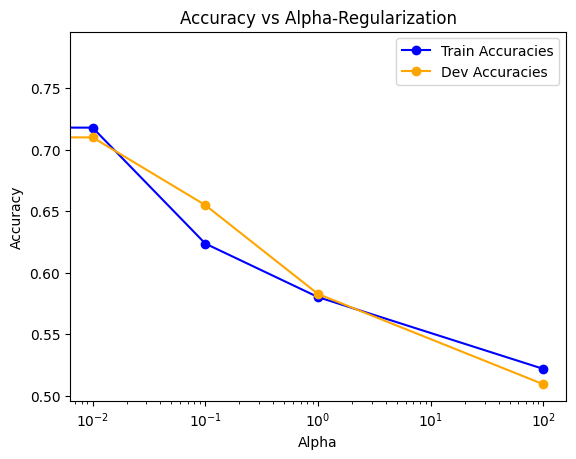

In [ ]:

# graph the results
import matplotlib.pyplot as plt

plt.plot(alphas, train_accuracies, marker='o', color='blue', label='Train Accuracies')
plt.plot(alphas, dev_accuracies, marker='o', color='orange', label='Dev Accuracies')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha-Regularization')

plt.legend()
plt.show()

**(b) Next, we would like to experiment with $l_2$ regularization $R(\theta) = \alpha\|\theta\|^2$. Plot the accuracy on train and development sets as a function of $\alpha = \{0, 10^{-2}, 10^{-1}, 1, 10\}$. You only need to experiment with unigram features for this part. Explain what you observe. Does this match what you would expect from regularization?**

The accuracy of train and dev sets largely decrease as alpha increases for the unigram model. This surprised me at first glance because I expected accuracy to improve with regularization; however, by observing the previous result, we know that the unigram model is pretty general and doesn't overfit strongly, so it makes sense that regularization doesn't have much positive effect. In going from alpha = 0 to alpha = 1e-2, we see a slight increase, before a pretty steep drop going to larger alpha values, which indicates that alpha = 1e-2 is probably a good regularization point for this model.

**(c) Based on your model’s performance in the previous experiment, propose one change you would consider
making to either the model or feature extraction pipeline to further improve development set performance.
Briefly describe the modification, explain why you expect it will improve validation perplexity, and discuss any
potential limitations.**

One approach would be to add a new dummy token in the vocab that represents all unseen words. This would get propagated to the feature vector (i.e. the token itself for unigram or as bigram combinations w/ other words for bigram), and ensures that rare words are somewhat represented semantically in context of other words when training the model. In this way, the dev data will be able to handle new words more robustly, and thereby lower validation perplexity altogether. However, the main limitation to this approach is that a large number of unseen/rare tokens get mapped to the same dummy token, thereby losing individual semantic meanings. This approach would work for handling the sparisty issue of very rare token occurences but not necessarily capture their semantic meaning.

# LLM Prompts

If you used an AI tool to complete any part of this assignment, please paste all prompts you used to produce your final code/responses in the box below and answer the following reflection question.

Prompts Used:
*   
*   



**Reflection: What parts of the AI generated output required modification or improvement? Describe the feedback you gave the tool to produce your final output or any changes you had to make on your own.**

TODO: ANSWER THE QUESTION HERE (DOUBLE-CLICK TO EDIT)